## Aprendizado Não Supervisionado - Agrupamento de Dados
#### Prof. Thomas da Silva Paula

### Avaliação de Agrupamento de Dados - Demo 1

* Utilização de diferentes algoritmos.
* Base de dados sintéticas que não possuem grupos.
* Motivação para métodos de avaliação de agrupamentos de dados.

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram

%matplotlib inline

np.random.seed(33)

sns.set(style='darkgrid', context='talk', rc={'figure.figsize': (14, 8)})

### Criar base de dados sintética

In [3]:
# Criamos uma base de dados com 500 instâncias e duas features
random_data = np.random.rand(500, 2)

df = pd.DataFrame(random_data, columns=['x', 'y'])
df.head()

,x,y
0,0.248510,0.449975
1,0.410941,0.260300
2,0.870396,0.185040
3,0.019661,0.953252
4,0.680451,0.486588


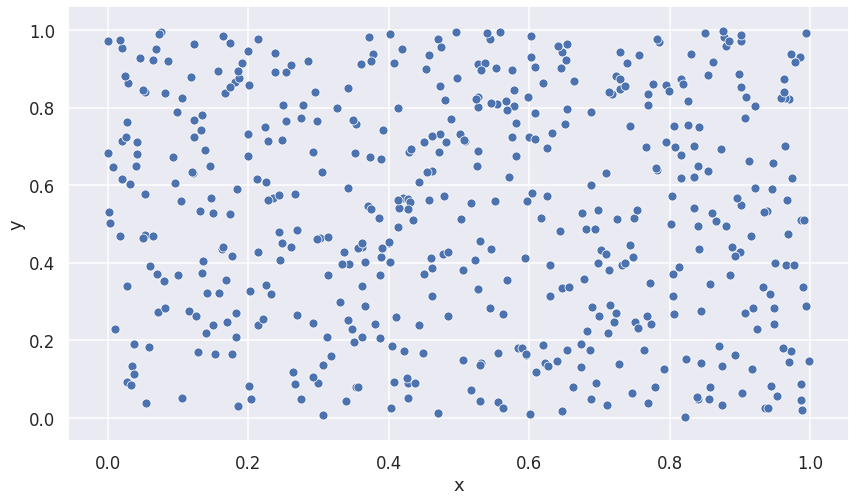

In [4]:
_ = sns.scatterplot(x='x', y='y', data=df, legend=False)

### K-Means

In [5]:
def train_and_plot_kmeans(data, k=3, init='k-means++', n_init=10, max_iter=300,
                          precompute_distances='auto', algorithm='auto', verbose=0, random_state=133):
    # Copiamos os dados
    data_copy = data.copy()
    
    model = KMeans(n_clusters=k, init=init, n_init=n_init, max_iter=max_iter,
                   precompute_distances=precompute_distances, algorithm=algorithm,
                   random_state=random_state, verbose=verbose)
    model.fit(data_copy)
    
    data_copy['cluster_labels'] = model.labels_
    _ = sns.scatterplot(x='x', y='y', data=data_copy, hue='cluster_labels', palette='rainbow', legend=False)

    centroids = model.cluster_centers_
    centroids_x = centroids[:,0]
    centroids_y = centroids[:,1]

    _ = plt.scatter(centroids_x, centroids_y, color='black', s=100)
    
    return model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=133, tol=0.0001, verbose=0)

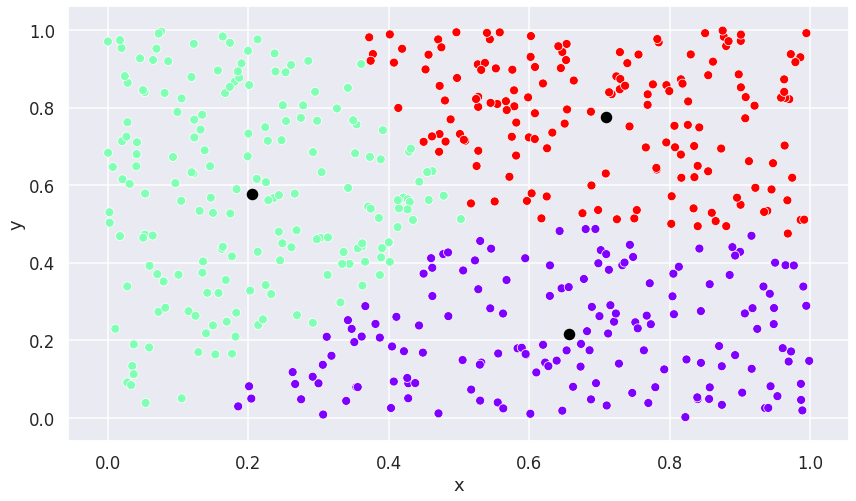

In [6]:
train_and_plot_kmeans(df, k=3)

### HAC

In [7]:
def train_and_plot_hac(data, method='single', metric='euclidean', threshold=2.0, pallete='viridis'):
    # Copiamos os dados
    data_copy = data.copy()    
    linkage_matrix = linkage(data_copy, method=method, metric=metric)
    labels = fcluster(linkage_matrix, threshold, 'distance')
    
    data_copy['cluster_labels'] = labels
    _ = sns.scatterplot(x='x', y='y', data=data_copy, hue='cluster_labels', palette=pallete, legend=False)
    
    return linkage_matrix, data_copy['cluster_labels']

Clusters: 1


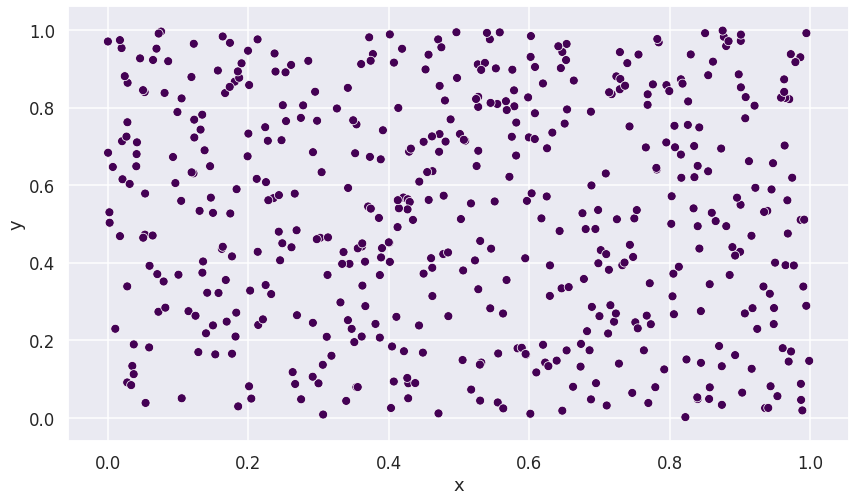

In [8]:
linkage_matrix, labels = train_and_plot_hac(df, method='single', threshold=10.0)
print('Clusters:', len(np.unique(labels)))

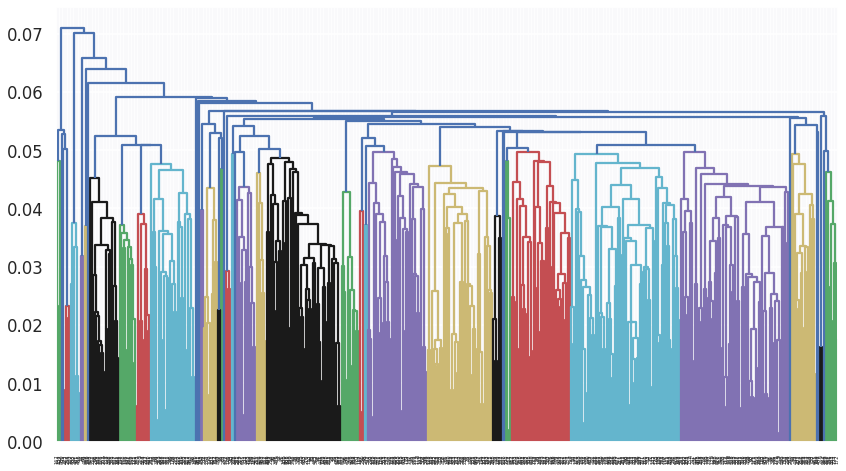

In [9]:
d = dendrogram(linkage_matrix)

Clusters: 6


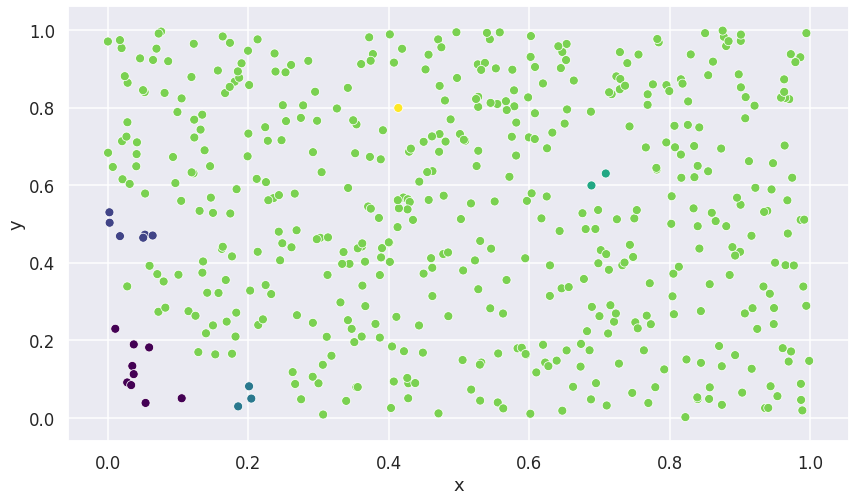

In [10]:
linkage_matrix, labels = train_and_plot_hac(df, method='single', threshold=0.06)
print('Clusters:', len(np.unique(labels)))

### GMM

In [11]:
def train_and_plot_gmm(data, k=3, covariance_type='full', tol=0.001, 
                       max_iter=100, n_init=1, init_params='kmeans', random_state=133):
    
    # Copiamos os dados 
    data_copy = data.copy()

    model = GaussianMixture(n_components=k, covariance_type=covariance_type, tol=tol,
                            max_iter=max_iter, n_init=n_init, init_params=init_params, random_state=random_state)
    model.fit(data_copy)
    
    data_copy['cluster_labels'] = model.predict(data_copy)
    _ = sns.scatterplot(x='x', y='y', data=data_copy, hue='cluster_labels', palette='rainbow', legend=False)

    means = model.means_
    means_x = means[:,0]
    means_y = means[:,1]

    _ = plt.scatter(means_x, means_y, color='black', s=100)
    
    w_factor = 0.2 / model.weights_.max()
    
    if covariance_type == 'tied':
        covars = np.repeat(model.covariances_, k, axis=0)
    else:
        covars = model.covariances_
        
    for pos, covar, w in zip(model.means_, covars, model.weights_):
        draw_ellipse(pos, covar, covariance_type, alpha=w * w_factor)
    
    return model

def draw_ellipse(position, covariance, covariance_type, ax=None, **kwargs):
    """
    Draw an ellipse with a given position and covariance
    
    Method adapted from: https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
    """
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    elif covariance_type == 'spherical':
        angle = 0
        width = 2 * np.sqrt(covariance)
        height = width
    else:
        angle = 0
        width, height = 2 * np.sqrt(np.abs(covariance))
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=133, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

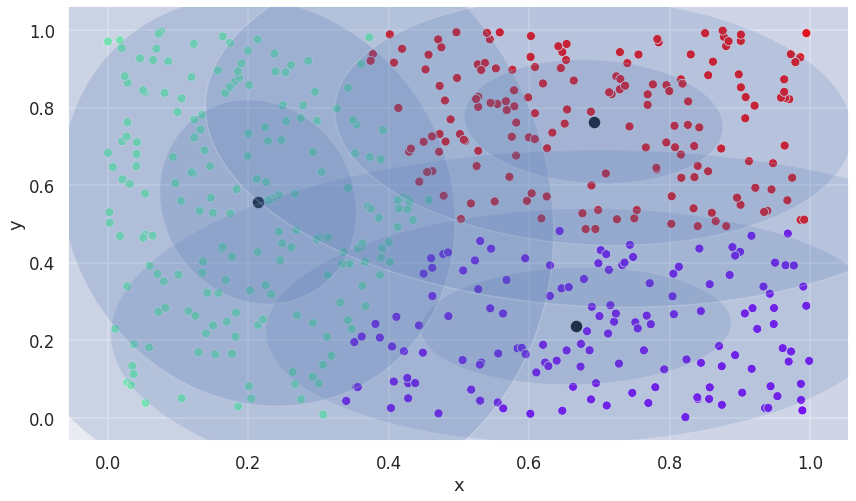

In [12]:
train_and_plot_gmm(df, k=3)

### DBSCAN

In [13]:
def train_and_plot_dbscan(data, eps=0.5, min_samples=5):
    
    # Copiamos os dados 
    data_copy = data.copy()
    
    model = DBSCAN(eps=eps, min_samples=min_samples)
    model.fit(data_copy)
    
    data_copy['cluster_labels'] = model.labels_
    _ = sns.scatterplot(x='x', y='y', data=data_copy, hue='cluster_labels', palette='rainbow', legend=False)

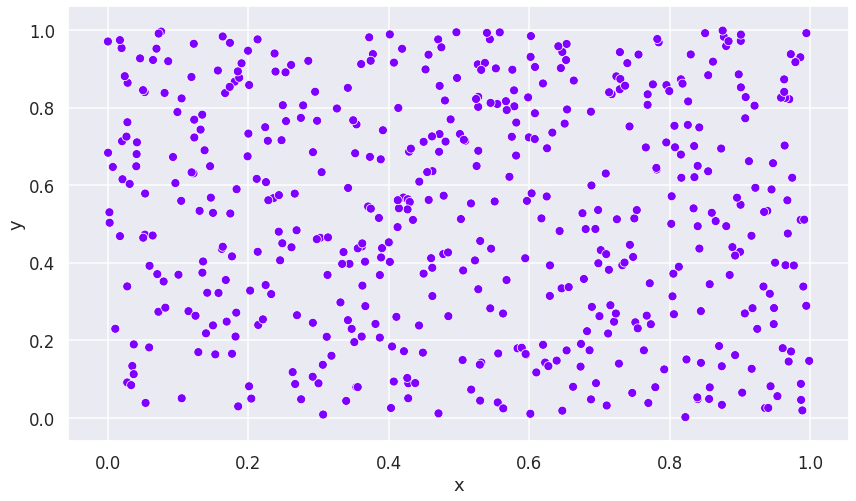

In [14]:
eps = 0.3
min_samples = 3

train_and_plot_dbscan(df, eps, min_samples)